#Semester Project : Implementation of a privacy preserving Spiking Neural Network through MPC


---

Yavuz AKIN, Nicolas SERVOT

last modification : 15 February 



---

Semester project at EURECOM (September 2021 -
February 2022)

Supervisors: Massimiliano TODISCO, Melek ÖNEN,
Oubaida CHOUCHA

Tasks accomplished:
Building SNN for Classification on MNIST

*   Building SNN for Classification on MNIST
*   Privacy-preserving testing using MPC (with Crypten)

INFO : To run the the Crypten testing part on GPU (with world_size=2 go check the modified code on the GitLab page, It may not work with this configuration on Colab)


## Loading libraries and initializing global variables

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

import pandas as pd

In [ ]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 28*28
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-3
nb_steps  = 100

batch_size = 256

In [ ]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda")     
else:
    device = torch.device("cpu")
    print("cpu")

cuda


## Dataset Construction

In [ ]:
# Here we load the Dataset
root = os.path.expanduser("~/data/datasets/torch/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/datasets/torch/fashion-mnist/FashionMNIST/raw



In [ ]:
# Standardize data
#x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
#x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

#y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
#y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=np.int)
y_test  = np.array(test_dataset.targets, dtype=np.int)

y_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/

(60000,)

(-0.5, 27.5, 27.5, -0.5)

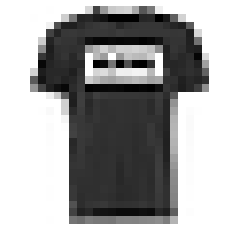

In [ ]:
# Here we plot one of the raw data points as an example
data_id = 1
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

REshaping the datatsets => shape of train is (60000,784),ie flatening the images matrix

In [ ]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    # T in [1.5,109]
    T[idx] = tmax

    return T
 

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
        nb_steps: number of time steps
        nb_units: 784 (28x28)
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int)
    # [0...783]
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        # index of the entry in the current batch
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        # batch index, absolute index in X
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            # keeps the entries such that time<100 
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [ ]:
T=current2firing_time(x_test)
df = pd.DataFrame(T)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.0,1.0,1.003667,1.002390,1.023809,1.035480,1.117476,1.486990,2.017968,3.257011,4.920690,6.255656,6.451172,6.333493,6.323815,6.861029,6.910054,5.687315,4.564518,2.827696,1.576791,1.310749,1.193173,1.187933,1.062696,1.024864,1.007970,1.002406,1.0,1.039307,1.017749,1.021856,1.078252,1.291572,1.927289,2.821164,3.559097,4.845284,5.064893,5.206644,...,4.915390,4.976235,5.054475,4.549793,4.216509,4.274646,3.427936,3.591838,2.999967,1.981783,1.421501,1.181930,1.011452,1.069164,1.225421,1.899921,3.089523,3.588672,3.862318,3.625073,4.319631,5.208095,6.444857,6.424866,6.411244,6.078417,5.303341,5.822237,6.240994,6.083010,5.780717,4.357482,3.592173,3.741058,3.297925,3.544148,2.579955,1.512261,1.232128,1.032410
std,0.0,0.0,0.239659,0.192421,0.783123,1.117769,3.483882,8.606353,9.221409,12.334875,14.346869,16.596867,15.906245,15.093312,14.197825,17.674953,18.667207,16.316309,15.957358,13.482974,5.054859,5.624342,3.600184,4.564974,1.413354,0.865160,0.654949,0.174908,0.0,3.006195,0.882254,0.655004,1.702460,4.876280,8.861921,10.490556,10.605189,14.836421,12.256836,9.363574,...,10.419820,10.816898,12.126249,11.117241,12.810451,13.433953,9.132231,11.471066,10.161380,8.288347,5.669281,5.285206,0.630222,3.077068,4.698259,8.938931,12.110862,12.534261,13.942601,13.186384,15.111311,15.127639,17.530865,14.419132,15.884367,17.014682,15.099516,15.688436,16.012658,15.550018,17.686318,14.651478,14.419675,15.499743,9.508204,13.038408,10.587615,5.421710,4.847282,2.899793
min,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1

## SNN model creation

In [ ]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [ ]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [ ]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")


In [ ]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient.
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [ ]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [ ]:
def train(x_data, y_data, lr=2e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output,_ = run_snn(x_local.to_dense())
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        

In [ ]:
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

## SNN Training

In [ ]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

Epoch 1: loss=0.93590
Epoch 2: loss=0.52856
Epoch 3: loss=0.47442
Epoch 4: loss=0.44522
Epoch 5: loss=0.42003
Epoch 6: loss=0.40063
Epoch 7: loss=0.38725
Epoch 8: loss=0.37511
Epoch 9: loss=0.36511
Epoch 10: loss=0.35576
Epoch 11: loss=0.35075
Epoch 12: loss=0.33949
Epoch 13: loss=0.33083
Epoch 14: loss=0.32491
Epoch 15: loss=0.31933
Epoch 16: loss=0.31451
Epoch 17: loss=0.30733
Epoch 18: loss=0.30243
Epoch 19: loss=0.29639
Epoch 20: loss=0.29093
Epoch 21: loss=0.28765
Epoch 22: loss=0.28414
Epoch 23: loss=0.27830
Epoch 24: loss=0.27513
Epoch 25: loss=0.27077
Epoch 26: loss=0.26585
Epoch 27: loss=0.26280
Epoch 28: loss=0.25866
Epoch 29: loss=0.25791
Epoch 30: loss=0.25222


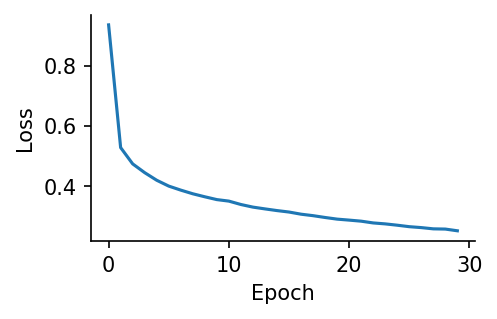

In [ ]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

## SNN Testing

In [ ]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.911
Test accuracy: 0.864


## Testing using secure MPC


---

This part of the project may not execute correctly when using GPU and world_size=2. To use GPU check our additional code on our GitLab page


In [ ]:
!pip install crypten

     |████████████████████████████████| 245 kB 5.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.7 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 12.7 MB 29.1 MB/s 
     |████████████████████████████████| 112 kB 47.7 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=04e84864ff161bae511f415b7a29fa7daa8a7f764ae85aaa21a0a17f3c4f2e6e
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency res

In [ ]:
import crypten
import crypten.mpc as mpc
import crypten.communicator as comm

In [ ]:
crypten.init()

In [ ]:
w_size=2
ALICE=0
BOB=1

In [ ]:
"""returns spikes"""

#@mpc.run_multiprocess(world_size=2)
def spike_fn_test(x):
    sub=torch.zeros(x.size(),dtype=float)
    sub.to(device)
    sub_enc=crypten.cryptensor(sub,device=device)
    out=x>sub_enc
    out.to(device)
 
    return out

In [ ]:
from numpy.core.arrayprint import format_float_scientific

#@mpc.run_multiprocess(world_size=2)
def run_snn_test(inputs,w1_enc,w2_enc):
    #h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    syn_enc=crypten.cryptensor(syn)
    mem_enc=crypten.cryptensor(mem)
    #print(syn_enc.device)
    #print(mem_enc.device)



    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
   # print("first hidden layer")
    mult_1=inputs.matmul(w1_enc)
    for t in range(nb_steps):
        #print("step number :"+str(t))
        mthr = mem_enc-crypten.cryptensor(1.0)
        #print(mthr.device)
        mthr.to(device)
        out = spike_fn_test(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn_enc*alpha +mult_1[:,t]
        new_mem = (beta*mem_enc +syn_enc)*(1.0-rst)

        mem_rec.append(mem_enc)
        spk_rec.append(out)
        
        mem_enc = new_mem
        syn_enc = new_syn

    mem_rec = crypten.stack(mem_rec,dim=1)
    spk_rec = crypten.stack(spk_rec,dim=1)

    #print(mem_rec.get_plain_text())
    print(spk_rec.get_plain_text())

    # Readout layer
    #print("readout layer")
    #h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    
    
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    #print("flt")
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    #print("out")

    flt_enc=crypten.cryptensor(flt)
    #print("flt")
    out_enc=crypten.cryptensor(out)
    #print("out")


    out_rec = []
    out_rec.append(out_enc)

    #print("entering for iteration")

    #print(w2_enc.get_plain_text())
    mult_2=spk_rec.matmul(w2_enc)
    for t in range(nb_steps):
        #print("step number :"+str(t))
        #if t<100 and t>95:
          #print(flt_enc.get_plain_text())
        new_flt = alpha*flt_enc +mult_2[:,t]
        new_out = beta*out_enc +flt_enc

        flt_enc = new_flt
        out_enc = new_out

        out_rec.append(out_enc)

    out_rec = crypten.stack(out_rec,dim=1)
    #print(out_rec.get_plain_text())
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [ ]:
%xmode Verbose

Exception reporting mode: Verbose


In [ ]:
#@mpc.run_multiprocess(world_size=2)
def compute_classification_accuracy_test(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """

    w1_enc=crypten.cryptensor(w1,src=0)
    w2_enc=crypten.cryptensor(w2,src=0)
    #print(w1_enc.device)

    #print(w2_enc.device)

    
    
    accs = []
    i=0
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        x_data_enc=crypten.cryptensor(x_local.to_dense())
        #print(x_data_enc.device)
        output_enc,_ = run_snn_test(x_data_enc,w1_enc,w2_enc)
        output=output_enc.get_plain_text()
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
        print(tmp)
        i+=1
    return np.mean(accs)

In [ ]:
%time a=compute_classification_accuracy_test(x_test,y_test)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [ ]:
print(a)

0.8470552884615384


In [ ]:
def run_snn_test_2(inputs,w1_enc,w2_enc):
    #h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((nb_hidden), device=device, dtype=dtype)

    syn_enc=crypten.cryptensor(syn)
    mem_enc=crypten.cryptensor(mem)
    #print(syn_enc.device)
    #print(mem_enc.device)



    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
   # print("first hidden layer")
    mult_1=inputs.matmul(w1_enc)
    for t in range(nb_steps):
        #print("step number :"+str(t))
        mthr = mem_enc-crypten.cryptensor(1.0)
        #print(mthr.device)
        mthr.to(device)
        out = spike_fn_test(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn_enc*alpha +mult_1[:,t]
        new_mem = (beta*mem_enc +syn_enc)*(1.0-rst)

        mem_rec.append(mem_enc)
        spk_rec.append(out)
        
        mem_enc = new_mem
        syn_enc = new_syn

    mem_rec = crypten.stack(mem_rec,dim=1)
    spk_rec = crypten.stack(spk_rec,dim=1)
    #print(spk_rec.size())


    #print(mem_rec.get_plain_text())
    #print(spk_rec.get_plain_text())

    # Readout layer
    #print("readout layer")
    #h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    
    
    flt = torch.zeros((nb_outputs), device=device, dtype=dtype)
    #print("flt")
    out = torch.zeros((nb_outputs), device=device, dtype=dtype)
    #print("out")

    flt_enc=crypten.cryptensor(flt)
    #print("flt")
    out_enc=crypten.cryptensor(out)
    #print("out")


    out_rec = []
    out_rec.append(out_enc)

    #print("entering for iteration")

    #print(w2_enc.get_plain_text())
    #print(spk_rec.matmul(w2_enc)[:,1].size())
    #print(flt_enc.size())

    mult_2=spk_rec.matmul(w2_enc)
    for t in range(nb_steps):
        #print("step number :"+str(t))
        #if t<100 and t>95:
          #print(flt_enc.get_plain_text())
        new_flt = alpha*flt_enc +mult_2[t,:]
        new_out = beta*out_enc +flt_enc

        flt_enc = new_flt
        out_enc = new_out

        out_rec.append(out_enc)

    out_rec = crypten.stack(out_rec,dim=1)
    #print(out_rec.get_plain_text())
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [ ]:
#@mpc.run_multiprocess(world_size=2)
def compute_classification_accuracy_test_2(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """

    w1_enc=crypten.cryptensor(w1,src=0)
    w2_enc=crypten.cryptensor(w2,src=0)
    #print(w1_enc.device)

    #print(w2_enc.device)

    
    
    accs = []
    
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        
        x_data_enc=crypten.cryptensor(x_local.to_dense())
        #print(x_data_enc.device)
        for i in range(batch_size):
          batch_am=[]
          output_enc,_ = run_snn_test_2(x_data_enc[i],w1_enc,w2_enc)
          #print(output_enc.size())
          output=output_enc.get_plain_text()
          m,_= torch.max(output,1) # max over time
          #print(m.size())
          _,am=torch.max(m,0)# argmax over output units
          #print(am)
          batch_am.append(am) 
        batch_am_stack=torch.stack(batch_am)       
        tmp = np.mean((y_local==batch_am_stack).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
        print(tmp)
          
    return np.mean(accs)

In [ ]:
%time a=compute_classification_accuracy_test_2(x_test,y_test)

0.10546875
0.08203125
0.078125
0.11328125


KeyboardInterrupt: ignored